In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

## 1) Generating an artificial image of the sky (frequency domain)

In [2]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 8.38266779e-03+1.23805674e-02j -6.68622041e-03-8.41651286e-04j
   5.78507222e-03-1.35949925e-02j -2.66239932e-03-1.23632746e-02j
  -1.75031386e-02-1.02102505e-02j -5.92487445e-03+5.42816985e-03j
  -4.67129052e-03-1.12960525e-02j  9.45288315e-03+6.35459274e-03j
   5.94043499e-03-3.85605963e-03j -7.93842785e-03-3.68373608e-03j
  -3.75526521e-04+1.44112138e-02j -5.77366725e-03+9.25998669e-03j
   6.64124126e-03+1.73435397e-02j  6.66224305e-03+8.56527127e-03j
   9.81507078e-03+1.30783743e-03j -4.94105229e-03+2.24101520e-03j
   1.57443043e-02-6.68880530e-03j  7.97130261e-03+1.77164357e-02j
  -1.13576697e-02+2.37605944e-02j  1.34594524e-02+1.08366637e-02j]
 [ 1.18464166e-02-4.93730791e-03j  1.92633420e-02+2.74964911e-03j
   2.56687850e-02+3.78465769e-03j  8.80937325e-04-7.95905106e-03j
  -1.03336321e-02-1.99748250e-03j  5.22264326e-03-1.21356137e-02j
   1.36181933e-03+1.85572691e-02j -1.73619725e-02+7.26049859e-03j
  -7.49628153e-03+1.14404578e-02j -5.25426003e-04-6.86933054e-03j
  -8.2283

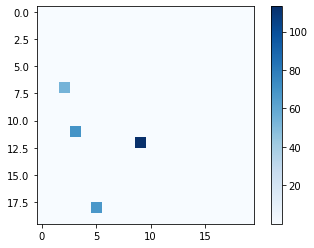

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [4]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 241.97237   +162.39954j      53.809708  -142.91866j
    60.68875    +19.199306j    -17.543806  -147.92075j
   -22.730068   +56.317253j     -8.324382  -160.15134j
  -189.7035    +112.45185j     104.77312    +65.69842j
   -19.01168    +28.24252j     126.1107     -57.17237j
  -185.70688    -70.84623j      45.252705  +184.202j
    44.09614    -44.020386j     87.48549    +66.47139j
    31.335312  -163.92044j     -47.563118   +68.386894j
    90.87694   -153.25621j    -208.74689    -41.120148j
   -50.98921    +52.871742j   -134.58165   +163.6251j    ]
 [-106.433784   -23.186335j     83.48725    -42.608418j
  -195.71988    -71.68894j      23.483849  +177.85799j
    26.645382   -40.80208j      67.830765   +51.532013j
   -43.028027  -167.13441j    -133.9476    +170.42802j
   138.25056    +27.299194j      0.91849333 +36.753593j
   147.73647    -76.286575j   -108.24277    -61.80817j
   114.5133      +1.7939435j  -130.28848   -186.76105j
  -118.58675    +96.3493j     -108.83201    +47.265614j
  

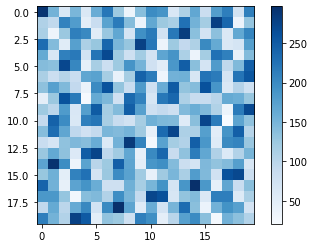

In [5]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 3) Source-finding classification

### Training labels

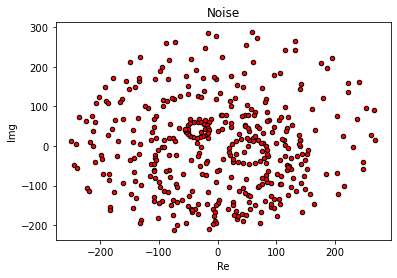

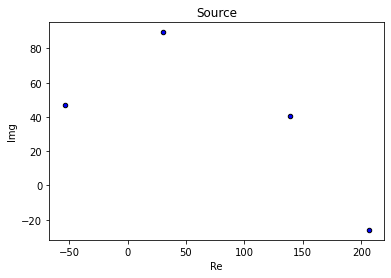

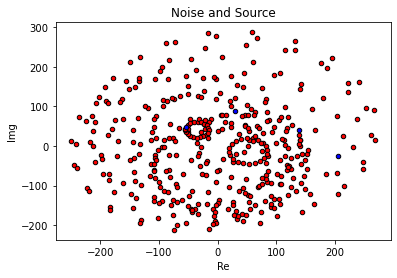

In [6]:
def labels(data, mask):
    
    Xvals, yvals = [], []
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == True:
                label = 1
            else:
                label = 0
        
            yvals.append(label)
            Xvals.append((data[i][j].real, data[i][j].imag))
        
    return pnp.array(Xvals, requires_grad=False), pnp.array(yvals, requires_grad=False)


def plot_data(x, y, ax=None):
    
    reds = y == 0
    blues = y == 1
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise')
    plt.show()
    
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Source')
    plt.show()
    
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise and Source')
    plt.show()
    
Xdata, ydata = labels(visibilities, mask)
plot_data(Xdata, ydata)


# Define output labels as quantum state vectors
def density_matrix(state):
    
    return state * pnp.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = pnp.array([label_0, label_1], requires_grad=False)

### Simple classifier with data reloading and fidelity loss

In [7]:
dev = qml.device("lightning.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend
# https://docs.pennylane.ai/projects/qiskit/en/latest/
# https://docs.pennylane.ai/en/stable/introduction/interfaces.html


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

### Utility functions for testing and creating batches

In [8]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return pnp.array(predicted), pnp.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

### Train a quantum classifier on the visibilities

In [9]:
# Generate training and test data
X_data, y_data = labels(visibilities, mask)
indices = []
for i in range(0, len(X_data)):
    indices.append(i)
random.shuffle(indices)

for i in range(0, len(X_data)):
    X_data[i] = X_data[indices[i]]
    y_data[i] = y_data[indices[i]]

index = int(0.8*len(X_data))
X_train, y_train = X_data[:index], y_data[:index]
X_test, y_test = X_data[index:], y_data[index:]

X_train = pnp.hstack((X_train, pnp.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = pnp.hstack((X_test, pnp.zeros((X_test.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 2
learning_rate = 1e-3
epochs = 20
batch_size = 64

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = pnp.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in tqdm(iterate_minibatches(X_train, y_train, batch_size=batch_size)):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

0it [00:00, ?it/s]

Epoch:  0 | Cost: 0.200025 | Train accuracy: 0.781250 | Test Accuracy: 0.737500


5it [00:21,  4.26s/it]
0it [00:00, ?it/s]

Epoch:  1 | Loss: 0.176507 | Train accuracy: 0.787500 | Test accuracy: 0.737500


5it [00:23,  4.66s/it]
0it [00:00, ?it/s]

Epoch:  2 | Loss: 0.175501 | Train accuracy: 0.787500 | Test accuracy: 0.737500


5it [00:22,  4.58s/it]
0it [00:00, ?it/s]

Epoch:  3 | Loss: 0.174513 | Train accuracy: 0.787500 | Test accuracy: 0.737500


5it [00:24,  4.97s/it]
0it [00:00, ?it/s]

Epoch:  4 | Loss: 0.173544 | Train accuracy: 0.787500 | Test accuracy: 0.737500


5it [00:25,  5.01s/it]
0it [00:00, ?it/s]

Epoch:  5 | Loss: 0.172598 | Train accuracy: 0.787500 | Test accuracy: 0.737500


5it [00:25,  5.00s/it]
0it [00:00, ?it/s]

Epoch:  6 | Loss: 0.171673 | Train accuracy: 0.787500 | Test accuracy: 0.737500


5it [00:23,  4.67s/it]
0it [00:00, ?it/s]

Epoch:  7 | Loss: 0.170770 | Train accuracy: 0.793750 | Test accuracy: 0.762500


5it [00:21,  4.38s/it]
0it [00:00, ?it/s]

Epoch:  8 | Loss: 0.169888 | Train accuracy: 0.793750 | Test accuracy: 0.762500


5it [00:24,  4.94s/it]
0it [00:00, ?it/s]

Epoch:  9 | Loss: 0.169029 | Train accuracy: 0.793750 | Test accuracy: 0.762500


5it [00:24,  4.95s/it]
0it [00:00, ?it/s]

Epoch: 10 | Loss: 0.168190 | Train accuracy: 0.793750 | Test accuracy: 0.762500


5it [00:25,  5.04s/it]
0it [00:00, ?it/s]

Epoch: 11 | Loss: 0.167373 | Train accuracy: 0.787500 | Test accuracy: 0.762500


5it [00:24,  4.88s/it]
0it [00:00, ?it/s]

Epoch: 12 | Loss: 0.166576 | Train accuracy: 0.787500 | Test accuracy: 0.762500


5it [00:23,  4.73s/it]
0it [00:00, ?it/s]

Epoch: 13 | Loss: 0.165798 | Train accuracy: 0.790625 | Test accuracy: 0.762500


5it [00:22,  4.56s/it]
0it [00:00, ?it/s]

Epoch: 14 | Loss: 0.165040 | Train accuracy: 0.790625 | Test accuracy: 0.762500


5it [00:25,  5.05s/it]
0it [00:00, ?it/s]

Epoch: 15 | Loss: 0.164301 | Train accuracy: 0.790625 | Test accuracy: 0.762500


5it [00:25,  5.15s/it]
0it [00:00, ?it/s]

Epoch: 16 | Loss: 0.163580 | Train accuracy: 0.790625 | Test accuracy: 0.762500


5it [00:24,  4.90s/it]
0it [00:00, ?it/s]

Epoch: 17 | Loss: 0.162876 | Train accuracy: 0.790625 | Test accuracy: 0.762500


5it [00:25,  5.19s/it]
0it [00:00, ?it/s]

Epoch: 18 | Loss: 0.162190 | Train accuracy: 0.790625 | Test accuracy: 0.762500


5it [00:20,  4.09s/it]
0it [00:00, ?it/s]

Epoch: 19 | Loss: 0.161520 | Train accuracy: 0.790625 | Test accuracy: 0.762500


5it [00:26,  5.39s/it]


Epoch: 20 | Loss: 0.160867 | Train accuracy: 0.790625 | Test accuracy: 0.762500


### Results

Cost: 0.160867 | Train accuracy 0.790625 | Test Accuracy : 0.762500
Learned weights
Layer 0: [0.51936576 0.13161656 0.170541  ]
Layer 1: [0.22135465 0.89281752 0.26019894]


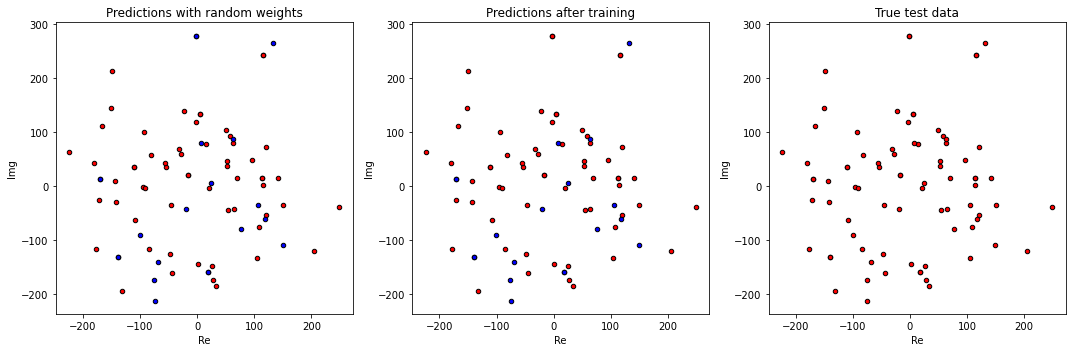

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


In [10]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

fig, axs = plt.subplots(1, 3, figsize=(15,5))
reds = initial_predictions == 0
blues = initial_predictions == 1
axs[0].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[0].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = predicted_test == 0
blues = predicted_test == 1
axs[1].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[1].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = y_test == 0
blues = y_test == 1
axs[2].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[2].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")

axs[0].set_title("Predictions with random weights")
axs[1].set_title("Predictions after training")
axs[2].set_title("True test data")

for ax in axs.flat:
    ax.set(xlabel='Re', ylabel='Img')

plt.tight_layout()
plt.show()

print(predicted_test - initial_predictions)